## Code snippet to connect mysql DB

In [1]:
#If mysql.connector package is missing, install it using below pip command in the console
#pip install mysql-connector-python
import mysql.connector as mysql


#In this query, configure the datails that match your mysql database
connection = mysql.connect(
    host="localhost",
    user="root",
    passwd="password",
    db="BookMeIn2")

## Installing required libraries for Data Analysis

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install numpy

In [ ]:
pip install textblob

## Importing Libraries required for the visualisation

In [2]:
#Pandas is used to convert the db data into dataframes which aids better visualisation techniques 
#If its missing install it by using below pip command in the console
#pip install pandas
import pandas as pd

#Using matplotlib.pyplot library to visualise charts
#If its missing install it by using below pip command in the console
#pip install matplotlib
import matplotlib.pyplot as plt

#Using seaborn package which aids in better visulisation 
#If its missing install it by using below pip command in the console
#pip install seaborn
import seaborn as sns

#NumPy is a Python library used for working with arrays operations
#If its missing install it by using below pip command in the console
#pip install numpy
import numpy as np

#Install Textblob for sentiment analysis 
#If its missing install it by using below pip command in the console
#pip install textblob
from textblob import TextBlob

## Analysis on Preregistration


### Question : What is the impact of preregistration?

In [3]:
#In read_sql_query function you can provide the sql query
#Query to get the total preregistered count from the registrations table

df1 = pd.read_sql_query('''SELECT count(*) as total_preregistered 
                           FROM registrations 
                           WHERE preregistration = 1''',connection)
#Query to get the total preregistered & registered count from the registrations table
df1['preregistered&registered'] = pd.read_sql_query('''SELECT count(*) 
                                                       FROM registrations 
                                                       WHERE preregistration = 1 AND registered= 1''',connection)

#Query to get the total preregistered but not registered count from the registrations table
df1['preregistered_not_registered'] = pd.read_sql_query('''SELECT count(*) 
                                                           FROM registrations 
                                                           WHERE preregistration = 1 AND registered= 0;''',connection)
df1

,total_preregistered,preregistered&registered,preregistered_not_registered
0,2480,400,2080


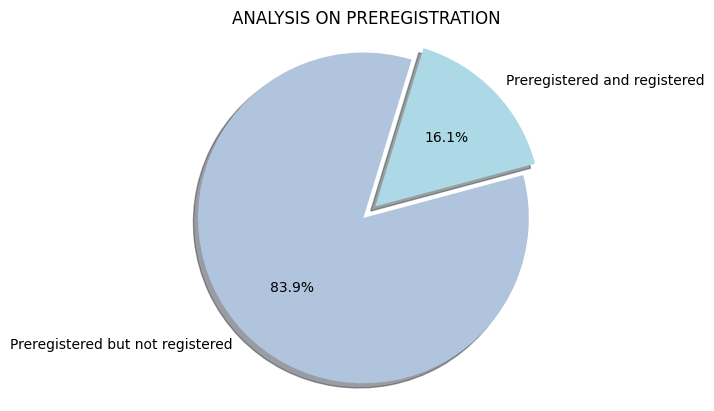

In [4]:
# Plotting the dataframe into piechart
data = [df1['preregistered&registered'][0],df1['preregistered_not_registered'][0]]
mylabels = ["Preregistered and registered","Preregistered but not registered" ]
my_colors = ['lightblue','lightsteelblue']
my_explode = (0, 0.1)
plt.pie(data, labels=mylabels, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('ANALYSIS ON PREREGISTRATION')
plt.axis('equal')
plt.show()


###### Analysis :
From the data, we found that more than 80% of the people who are doing a preregistration of the event are not at all registering the event later.Only less than 20% of people are coming later.Attendees might have preregistered when they got the mail invite, but later forget to attend the event. We need to avoid this by increasing the visibility of the event, by  sending gentle reminder mails ,colourful brochures of the event and if possible announcements via social media.

## Analysis on Registration


### Question : How many delegates registered ?

#### Analysis on Registered attendees based on Attendee Type

In [5]:
#Query to get the total registered count from the registrations table
df2 = pd.read_sql_query('''SELECT count(distinct (attendee_id)) as total_registered 
                           FROM registrations 
                           WHERE registered = 1''',connection)

#Query to get the total deligate count 
df2['Delegate'] = pd.read_sql_query('''with t1 as(
                                        SELECT attendees.id as attendee_id,attendees.typeid,
                                        registrations.registered,registrations.event_id
                                        FROM attendees 
                                        INNER JOIN registrations 
                                        ON attendees.id = registrations.attendee_id 
                                        WHERE attendees.typeid=327 AND registrations.registered=1
                                       )SELECT count(distinct(attendee_id)) FROM t1;''',connection)
#Query to get the total exhibitor count 
df2['Exhibitor'] = pd.read_sql_query('''with t1 as(
                                        SELECT attendees.id as attendee_id,attendees.typeid,
                                        registrations.registered,registrations.event_id
                                        FROM attendees 
                                        INNER JOIN registrations 
                                        ON attendees.id = registrations.attendee_id 
                                        WHERE attendees.typeid=328 AND registrations.registered=1
                                       )SELECT count(distinct(attendee_id)) FROM t1;''',connection)

df2 = df2.T
df2 = df2.drop('total_registered')
df2


,0
Delegate,478
Exhibitor,936


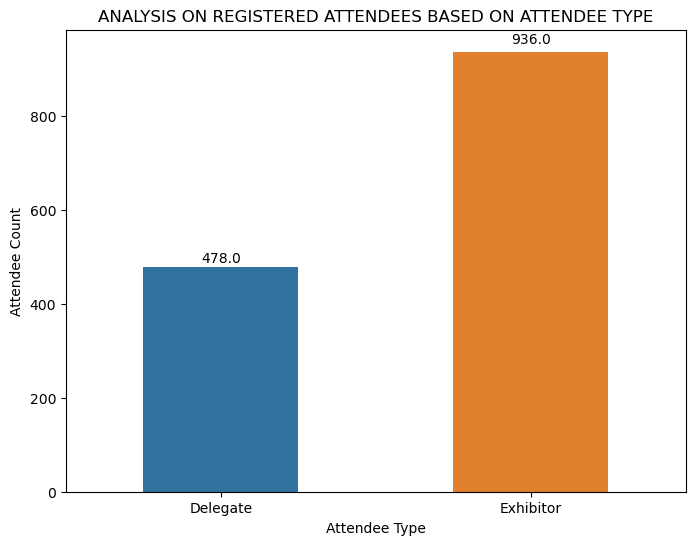

In [6]:
# Plotting the dataframe into bar chart

# Set the width and height of the figure
plt.figure(figsize=(8,6))

# Add title
plt.title("ANALYSIS ON REGISTERED ATTENDEES BASED ON ATTENDEE TYPE")

ax = sns.barplot(x=df2.index, y=df2[0])

#Add label for horizontal axis
plt.xlabel("Attendee Type")

# Add label for vertical axis
plt.ylabel("Attendee Count")

#function to print stats over the bars 
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')
    

#function to change the width of the bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

#Calling change_width function
change_width(ax, .5)

#To display the prepared graph   
plt.show()


###### Analysis :
We observed that 1428 attendees registered for the various events.
Out of this 1428, 478 people are Delegates and 936 people are Exhibitors.
From the bar graph, it’s evident that delegate’s count is around 50% of the exhibitor’s count.

### Question : How many delegates attended ?

#### Analysis on Registered attendees based on Event Type

In [44]:
#Created view : reg_events_view
'''
CREATE VIEW reg_events_view AS 
SELECT events.event_type,events.start_time,events.end_time,events.seminar_video_link,
events.question_to_delegate_pre_count,events.question_to_delegate_during_count,events.question_to_delegate_after_count,
registrations.id,registrations.preregistration,registrations.time_registered,registrations.registered,
registrations.event_id,registrations.attendee_id,registrations.greeting_notes
FROM events
INNER JOIN registrations 
ON events.id = registrations.event_id;
'''

#Created view : reg_event_attendee_view
'''
CREATE VIEW reg_event_attendee_view AS
SELECT reg_events_view.event_type,reg_events_view.preregistration,reg_events_view.time_registered,
reg_events_view.registered,reg_events_view.event_id,reg_events_view.attendee_id,
attendees.typeid
FROM reg_events_view
INNER JOIN attendees 
ON attendees.id = reg_events_view.attendee_id;
'''

#Created view : reg_attendee_session_tracking_view
'''
CREATE VIEW reg_attendee_session_tracking_view AS 
SELECT attendee_session_tracking.attendeeid,attendee_session_tracking.eventid,attendee_session_tracking.date_pinged, 
registrations.id,registrations.preregistration,registrations.time_registered,registrations.registered,
registrations.event_id,registrations.greeting_notes
FROM attendee_session_tracking
INNER JOIN registrations 
ON attendee_session_tracking.attendeeid = registrations.attendee_id;
'''


'\nCREATE VIEW reg_attendee_session_tracking_view AS \nSELECT attendee_session_tracking.attendeeid,attendee_session_tracking.eventid,attendee_session_tracking.date_pinged, \nregistrations.id,registrations.preregistration,registrations.time_registered,registrations.registered,\nregistrations.event_id,registrations.greeting_notes\nFROM attendee_session_tracking\nINNER JOIN registrations \nON attendee_session_tracking.attendeeid = registrations.attendee_id;\n'

In [7]:
#Deligates registered for the front door event
df3 = pd.read_sql_query('''SELECT count(distinct(attendee_id)) AS front_door_event_delegates_count
                           FROM reg_event_attendee_view 
                           WHERE registered =1 AND event_type =377 AND typeid=327;''',connection)

#Deligates registered for the Exhibition Stand door event
df3['exhibition_stand_door_event_delegates_count'] = pd.read_sql_query('''SELECT count(distinct (attendee_id)) 
                                                                          FROM reg_event_attendee_view 
                                                                          WHERE registered =1 AND event_type =379 
                                                                          AND typeid=327;''',connection)

#Exhibitors registered for the front door event
df3['front_door_event_exhibitors_count'] = pd.read_sql_query('''SELECT count(distinct(attendee_id)) 
                                                                FROM reg_event_attendee_view 
                                                                WHERE registered =1 AND event_type =377 
                                                                AND typeid=328;''',connection)

#Exhibitors registered for the Exhibition Stand door event
df3['exhibition_stand_door_event_exhibitors_count'] = pd.read_sql_query('''SELECT count(distinct(attendee_id)) 
                                                                           FROM reg_event_attendee_view 
                                                                           WHERE registered =1 AND event_type =379 
                                                                           AND typeid=328;''',connection)

#Deligates registered for the seminar event
df3['seminar_event_delegates_count'] = pd.read_sql_query('''with t1 as(
                                                            SELECT attendeeid,eventid,registered,event_id,
                                                            attendees.typeid
                                                            FROM reg_attendee_session_tracking_view
                                                            INNER JOIN attendees 
                                                            ON attendees.id = reg_attendee_session_tracking_view.attendeeid 
                                                            WHERE registered=1 AND typeid=327
                                                            )SELECT count(distinct(attendeeid)) from t1;''',connection)

#Exhibitors registered for the seminar event
df3['seminar_event_exhibitors_count'] = pd.read_sql_query('''with t1 as(
                                                            SELECT attendeeid,eventid,registered,event_id,
                                                            attendees.typeid
                                                            FROM reg_attendee_session_tracking_view
                                                            INNER JOIN attendees 
                                                            ON attendees.id = reg_attendee_session_tracking_view.attendeeid 
                                                            WHERE registered=1 AND typeid=328
                                                            )SELECT count(distinct(attendeeid)) from t1;''',connection)
df3

,front_door_event_delegates_count,exhibition_stand_door_event_delegates_count,front_door_event_exhibitors_count,exhibition_stand_door_event_exhibitors_count,seminar_event_delegates_count,seminar_event_exhibitors_count
0,427,274,775,590,48,88


In [8]:
#Creating dataframe from the above data to plot on barchart
plotdata = pd.DataFrame({
    "Delegate":[df3['front_door_event_delegates_count'][0],df3['seminar_event_delegates_count'][0],df3['exhibition_stand_door_event_delegates_count'][0]],
    "Exhibitor":[df3['front_door_event_exhibitors_count'][0],df3['seminar_event_exhibitors_count'][0],df3['exhibition_stand_door_event_exhibitors_count'][0]]    
    }, 
    index=["Front door", "Seminar","Exhibition Stand door"]
)
plotdata

,Delegate,Exhibitor
Front door,427,775
Seminar,48,88
Exhibition Stand door,274,590


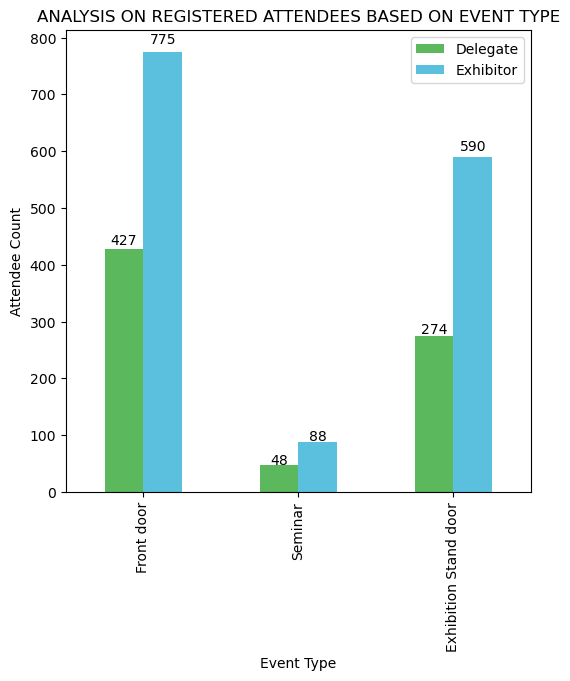

In [9]:
#Plotting the created dataframe into bar chart

#set the colors
colors = ['#5cb85c', '#5bc0de']

ax = plotdata.plot(kind="bar" ,figsize=(6,6), width=0.5 ,color = colors)

#Add title
plt.title("ANALYSIS ON REGISTERED ATTENDEES BASED ON EVENT TYPE")

#Add label for horizontal axis
plt.xlabel("Event Type")

# Add label for vertical axis
plt.ylabel("Attendee Count")

#function to print stats over the bars 
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')
    
plt.show()

###### Analysis :
Here we are going to analyse the registered attendees based on the event type.
So we could see most of the attendees preferred front door event.
In case of virtual attendees, we could see a total of 132 attendees registered for Seminar and in this 48 attendees were delegates and 88 were exhibitors.
For exhibition stand door event,274 delegates were registered.
In every event type, could see delegate’s count is around 50% of the  exhibitor’s count.

## Analysis on attendee_stand_tracking


In [48]:
#Created view : attendee_stand_tracking_view
'''
CREATE VIEW attendee_stand_tracking_view AS 
SELECT attendee_stand_tracking.attendeeid,attendee_stand_tracking.eventid,attendee_stand_tracking.date_pinged,
attendees.typeid,attendees.exhibitoraccount 
FROM attendee_stand_tracking 
INNER JOIN attendees 
ON attendees.id = attendee_stand_tracking.attendeeid;
'''


'\nCREATE\xa0VIEW attendee_stand_tracking_view AS \nSELECT attendee_stand_tracking.attendeeid,attendee_stand_tracking.eventid,attendee_stand_tracking.date_pinged,\nattendees.typeid,attendees.exhibitoraccount \nFROM attendee_stand_tracking \nINNER JOIN attendees \nON attendees.id = attendee_stand_tracking.attendeeid;\n'

### Question : How long did virtual delegates attend for the stand ?

In [10]:
#Query to know, how long did virtual delegates attend for the stand
df4 = pd.read_sql_query('''SELECT attendeeid, (count(*) / 6) as duration 
                           FROM attendee_stand_tracking_view 
                           WHERE typeid=327 
                           GROUP BY attendeeid;''',connection)
df4.index = df4.attendeeid
del df4['attendeeid']
df4.head()


,duration
attendeeid,
22173,0.8333
22174,0.8333
22175,0.8333
22176,0.8333
22425,0.8333


In [11]:
#The describe() method returns description of the data in the DataFrame. 
#If the DataFrame contains numerical data, the description contains these information for each column: 
#count - The number of not-empty values. 
#mean - The average (mean) value.
#minimum,maximum,standard deviation etc
df4.describe()

,duration
count,44.000000
mean,3.651500
std,4.786096
min,0.166700
25%,0.333300
50%,0.833300
75%,6.666700
max,13.333300


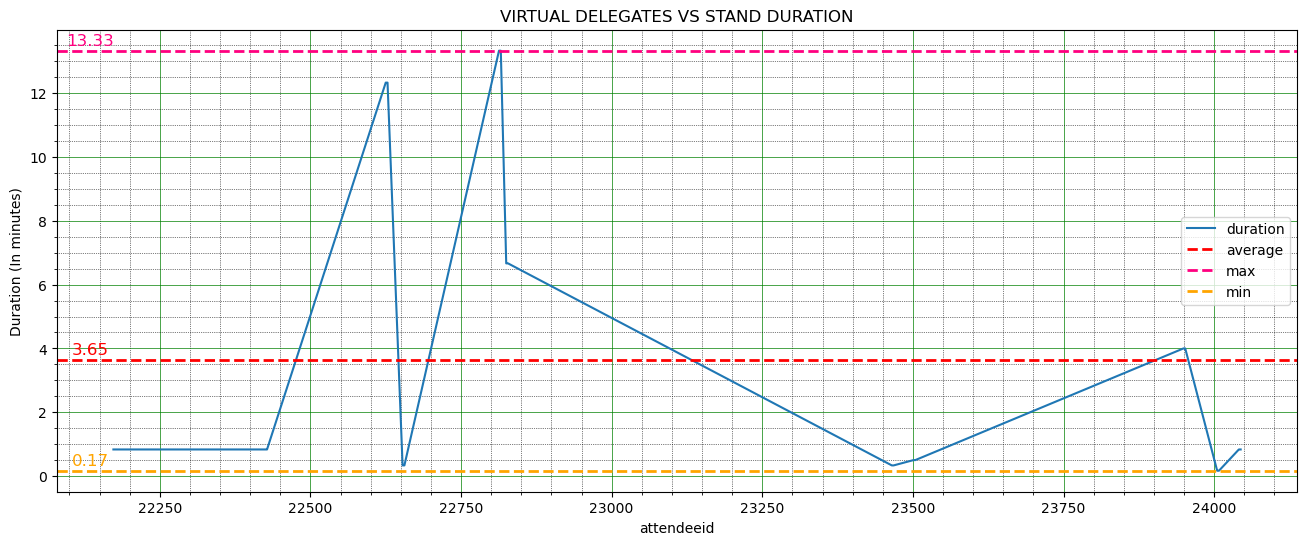

In [12]:
#Plotting line chart with attendee id on x-axis and their duration on y-axis 

# Set the width and height of the figure
plt.figure(figsize=(16,6))

#Set the backgroud for the graph
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Line chart 
graph = sns.lineplot(data=df4)
#Set the mean dashed line on the line chart
graph.axhline(df4.duration.mean(),linewidth=2, color='r',linestyle='dashed',label="average")
#Set the mean value over the created dashed line 
plt.text(22135,df4.duration.mean()+0.3, round(df4.duration.mean(), 2), fontsize=12,color='r', va='center', ha='center')

#Set the max dashed line on the line chart
graph.axhline(df4.duration.max(),linewidth=2, color='#FF007F',linestyle='dashed',label="max")
#Set the max value over the created dashed line 
plt.text(22135,df4.duration.max()+0.3, round(df4.duration.max(), 2), fontsize=12,color='#FF007F', va='center', ha='center')

#Set the min dashed line on the line chart
graph.axhline(df4.duration.min(),linewidth=2, color='#FFA500',linestyle='dashed',label="min")
#Set the min value over the created dashed line 
plt.text(22135,df4.duration.min()+0.3, round(df4.duration.min(), 2), fontsize=12,color='#FFA500', va='center', ha='center')


plt.legend()

plt.title("VIRTUAL DELEGATES VS STAND DURATION")
plt.ylabel("Duration (In minutes)")

plt.show()

###### Analysis :
From the line graph, we could observe virtual delegates spend an average of 3.6 minutes on stand.
Maximum time spend on the stand is 13.3 minutes where as minimum time spend is 0.16 minutes.

### Question : How long did virtual delegates attend for? Again, may be difficult as we can not track when they log off. Yet we do know when they were watching a live session.

In [ ]:
# The following views were created in SQL to capture the 'pings' for each delegate across both their time at 
# stands as well as their time spent viewing sessions.
'''
CREATE VIEW SessionTracking (EVENT_ID, DELEGATE, STAMP) AS 
SELECT eventid, attendeeid, date_pinged 
FROM attendee_session_tracking 

CREATE VIEW StandTracking (EVENT_ID, DELEGATE, STAMP) AS 
SELECT eventid, attendeeid, date_pinged 
FROM attendee_stand_tracking 

CREATE VIEW SessionStandTrackingUnion AS 
(SELECT *  FROM SessionTracking UNION SELECT * FROM StandTracking) 
'''

In [3]:
# Using the created views, Python code was used to access SQL directly and create a Pandas dataframe which listed each delegates
# time spent viewing online material.  Their time spent viewing (in minutes) was calculated by capturing the total amount of 'pings'
# divided by 6 (due to the time stamps being captured every 10 seconds)
Delegate_Time_Log = pd.read_sql_query('SELECT DELEGATE, (count(STAMP) / 6) AS MINS_ONLINE FROM attendees, SessionStandTrackingUnion where DELEGATE = id and typeid = 327 group by DELEGATE order by DELEGATE; ',connection)
Delegate_Time_Log.head()

,DELEGATE,MINS_ONLINE
0,22101,154.0000
1,22102,154.0000
2,22103,154.0000
3,22104,154.0000
4,22105,187.8333


In [4]:
# A further dataframe was created using the above mentioned technique to calculate the number of minutes each delegate spent viewing
# each session/stand
Event_Time_Log = pd.read_sql_query('SELECT DELEGATE, EVENT_ID, (count(STAMP) / 6) AS MINS_IN_EVENT FROM attendees, SessionStandTrackingUnion where DELEGATE = id and typeid = 327 group by DELEGATE, EVENT_ID order by DELEGATE, EVENT_ID; ',connection)
Event_Time_Log.head()

,DELEGATE,EVENT_ID,MINS_IN_EVENT
0,22101,4115,8.6667
1,22101,4117,0.1667
2,22101,4118,10.5000
3,22101,4120,8.6667
4,22101,4124,1.3333


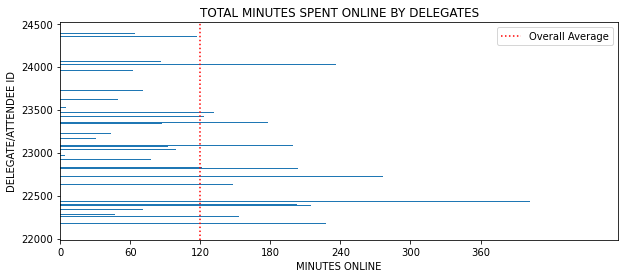

In [5]:
# Matplotlib was used to plot a bar graph which highlighted the amount of time spent online by delegates

# Setting the size of the graph
plt.figure(figsize=(10,4))
# Command for a horizontal bar graph.  This was selected as the dataset is large and therfore easier to interpret with this 
# layout
plt.barh(Delegate_Time_Log.DELEGATE,Delegate_Time_Log.MINS_ONLINE)
plt.title('TOTAL MINUTES SPENT ONLINE BY DELEGATES')
plt.ylabel('DELEGATE/ATTENDEE ID')
plt.xlabel('MINUTES ONLINE')
plt.axvline((Delegate_Time_Log["MINS_ONLINE"].mean()), color='red', ls='dotted')
plt.xticks(np.arange(0, 420, 60))
plt.yticks(np.arange(22000, 25000, 500))
plt.legend(['Overall Average'])
plt.show()

The chart highlights an average 'viewing time' of only two hours for an all day event, with some outliers pushing that average up. Further data could be collected from users as they log out, such as a simple star rating for each event they have viewed.  This would allow for analysis of user satisfation.  Furthermore, this data has been collated using screen 'pings' and much more accurate information about 'viewing times' could be sourced if users' time online was recorded with a 'session timer.'

In [6]:
Event_Time_Log.sort_values(by=['EVENT_ID'], inplace=True)
Event_Time_Log.EVENT_ID = Event_Time_Log.EVENT_ID.astype(str)

In [ ]:
# Further views were created in SQL to allow for another dataframe containing the average time spent by users at each session/stand
# along with the maximum and minimum time spent at each by delegates 
'''
CREATE VIEW EVENT_VIEWER_TIMES (DELEGATE, EVENT_ID, MINUTES_VIEWED) AS SELECT DELEGATE, EVENT_ID, (count(STAMP) / 6) FROM attendees, SessionStandTrackingUnion  where DELEGATE = id and typeid = 327 and exhibitoraccount = 0 group by DELEGATE, EVENT_ID order by EVENT_ID; 
'''


In [7]:
# Pandas dataframe outlining viewing statistics for specific events
EVENT_ATTENDANCE_DETAILS = pd.read_sql_query('SELECT EVENT_ID, COUNT(DELEGATE),  AVG(MINUTES_VIEWED), MIN(MINUTES_VIEWED), max(MINUTES_VIEWED) FROM EVENT_VIEWER_TIMES GROUP BY EVENT_ID; ',connection)
EVENT_ATTENDANCE_DETAILS.head()

,EVENT_ID,COUNT(DELEGATE),AVG(MINUTES_VIEWED),MIN(MINUTES_VIEWED),max(MINUTES_VIEWED)
0,4115,324,56.018521,2.1667,157.3333
1,4116,184,14.112324,0.1667,29.0000
2,4117,256,9.815106,0.1667,33.0000
3,4118,84,8.587300,0.1667,23.8333
4,4119,60,4.766667,0.1667,18.0000


In [8]:
# Converting numerical data into string format to allow for better visualisation
EVENT_ATTENDANCE_DETAILS.sort_values(by=['EVENT_ID'], inplace=True)
EVENT_ATTENDANCE_DETAILS.EVENT_ID = EVENT_ATTENDANCE_DETAILS.EVENT_ID.astype(str)

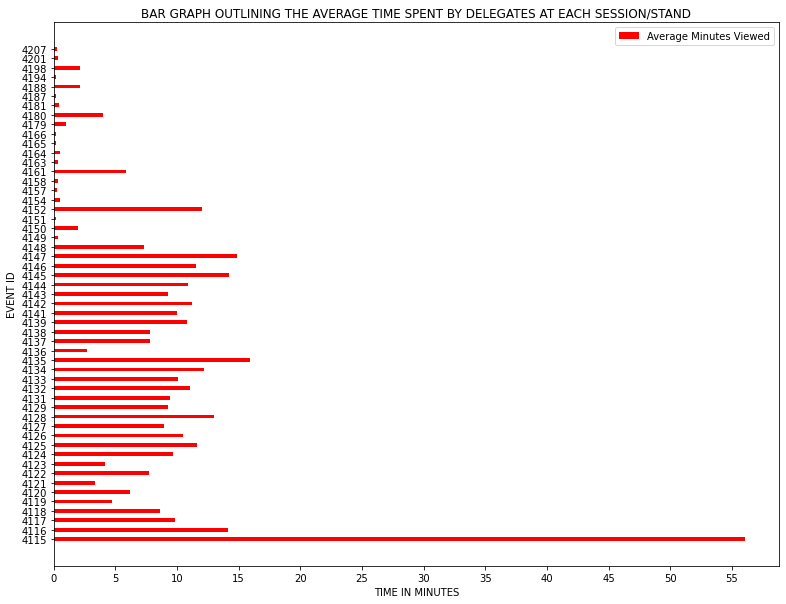

In [12]:
# Matplotlib commands to plot bar graph outlining the average time spent by delegates at each stand/session
ypos = np.arange(len(EVENT_ATTENDANCE_DETAILS.EVENT_ID))
plt.figure(figsize=(13, 10))
plt.xticks(np.arange(0,60, 5))
plt.yticks(ypos, EVENT_ATTENDANCE_DETAILS.EVENT_ID)

plt.barh(ypos, EVENT_ATTENDANCE_DETAILS ['AVG(MINUTES_VIEWED)'], height=0.4, color='red', label = 'Average Minutes Viewed')

plt.title('BAR GRAPH OUTLINING THE AVERAGE TIME SPENT BY DELEGATES AT EACH SESSION/STAND')
plt.ylabel('EVENT ID')
plt.xlabel('TIME IN MINUTES')
plt.legend()

plt.show()


### Question : Did anyone attend in-person and then log on later to view the information and or network?

In [ ]:
# This question required the joining of tables in SQL.  This allowed for the attendee log (which contains data about online attendees)
# to be queried alongside the 'attendees' table which held information on in-person attendees)

In [46]:
# The number of delegates attending online and in person was sourced by selecting the in-person attendees' 'attendeeid' from the
# 'attendee_log' table then applying a 'count' query.  An inner join allowed for only 'delegates' to be selected by searching their
# 'typeid' (327)
Dual_Attendees = pd.read_sql_query('''

                                     with t1 as (
SELECT event_type,registered,event_id,attendee_id,typeid,reftype 
from  BookMeIn2.reg_event_attendee_view 
inner join BookMeIn2.attendee_log on
BookMeIn2.reg_event_attendee_view.attendee_id = BookMeIn2.attendee_log.attendeeid 
where registered=1 and event_type=377 and typeid=327 and reftype='login'
)
SELECT distinct (attendee_id) FROM t1;

''',connection)

Dual_Attendees_count = len(Dual_Attendees)

In [38]:
# A further dataframe was created to capture the number of delegates who attended in-person
Physical_Attendees = pd.read_sql_query('SELECT * FROM BookMeIn2.reg_event_attendee_view where registered =1 and event_type =377 and typeid=327; ',connection)

In [47]:
# This query counts the number of physical attendees 
Physical_Attendees_count = len(Physical_Attendees)

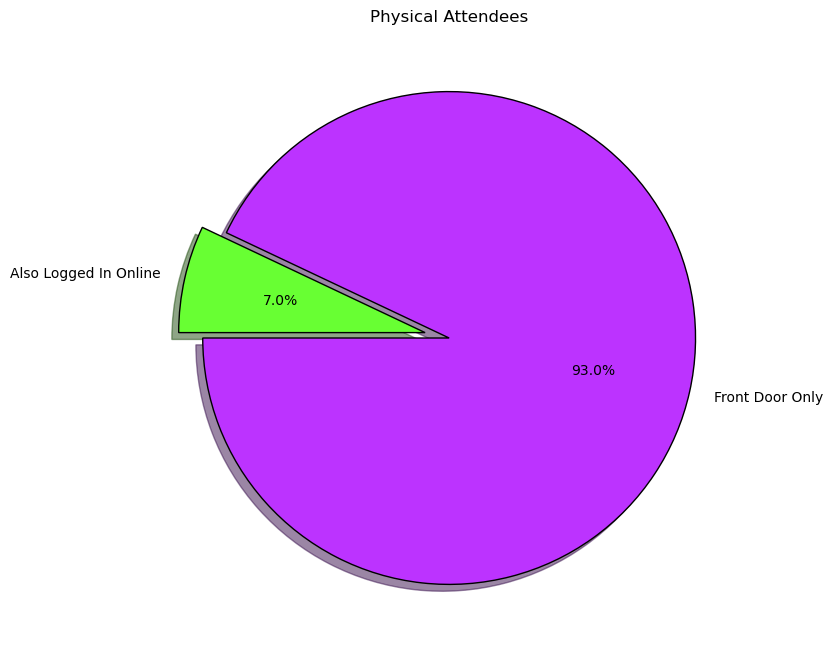

In [48]:
# Below are Python commands to define the number of physical attendees along with those who attended both in-person and online 
FrontDoorOnlyAttendees = Physical_Attendees_count - Dual_Attendees_count
FrontDoorAndOnline = Dual_Attendees_count
# The below are definitions used for the pie plot used to visualise the percentage of attendees who attended in-person and online
Slices = [FrontDoorOnlyAttendees,FrontDoorAndOnline]
labels = ['Front Door Only', 'Also Logged In Online']
colors = ['#BC33FF', '#68FF33']
explode = [0, 0.1]
# Matplotlib code for the development of a piechart
plt.figure(figsize=(8,8))
plt.pie(Slices, labels=labels, colors=colors, explode=explode, shadow=True, startangle=180, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})
plt.title("Physical Attendees")
plt.show()

The pie chart highlights that only 7% of those attending in-person, later logged in online.  Further information could be sought from those who have not logged into the online platform as to the reasons why.  Potentially through the use of a follow up questionaire.  This should contain questions about networking, for example, wehther they gained any leads and whether these were followed up.

### Question : When did delegates attend? This may be difficult as we only record the last time they  logged on

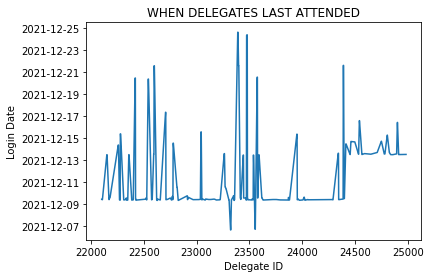

In [13]:
#The below query is selecting the (id, first_name, last_name, typeid, last_user_login) columns from the the table 
#attendees on the condition that the column last_user_login should not be blank or empty. 
df31 = pd.read_sql_query('SELECT id, first_name, last_name, typeid, last_user_login FROM attendees WHERE last_user_login IS NOT null and typeid = 327;',connection)
df31
plt.plot(df31.id,df31.last_user_login)
plt.title("WHEN DELEGATES LAST ATTENDED")
plt.xlabel("Delegate ID")
plt.ylabel("Login Date")
plt.show()

### Question : Which sessions were popular and why?

In [14]:
#The below query uses the count function on the column attendeeid and giving it a new name as group_total 
#by selecting from the table attendee_session_tracking and then grouping the records by eventid so that  

we can count the attendeeids in each event group. 
df91 = pd.read_sql_query("SELECT count(distinct(attendeeid)) as group_total, eventid FROM attendee_session_tracking group by eventid;", connection)
df91.head()

,group_total,eventid
0,404,4115
1,228,4116
2,324,4117
3,116,4118
4,88,4119


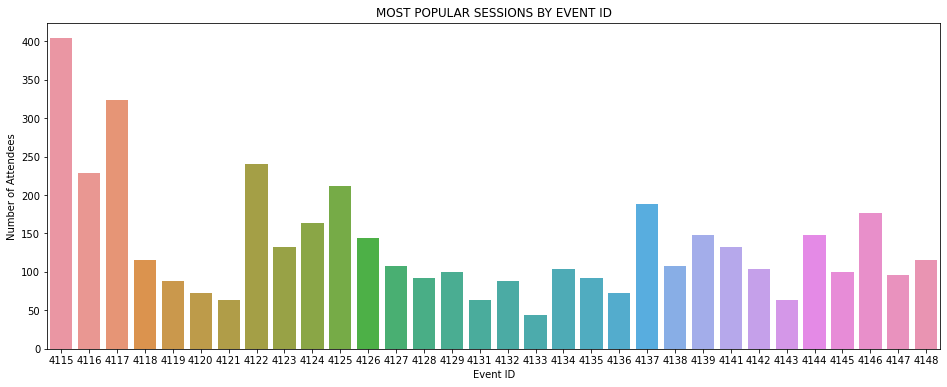

In [16]:
plt.figure(figsize=(16,6))
sns.barplot(x=df91['eventid'], y=df91['group_total'])
plt.title("MOST POPULAR SESSIONS BY EVENT ID")
plt.xlabel("Event ID")
plt.ylabel("Number of Attendees")
plt.show()

### Question : Which features did the virtual attendees use the most?

In [17]:
# Here wis the query for capturing check how people used various features of of web site
# We can know how people logging in actually visited stand pages and seminar videos
# Query to select Data
online_usage_type_df = pd.read_sql_query('''
                            SELECT  reftype as usage_type, count(distinct(attendeeid)) as no_of_people from attendee_log log
                            Inner Join attendees att on log.attendeeid = att.id and att.exhibitoraccount = 0
                            group by refType
                            order by no_of_people desc''',connection)


# Data cleanup -- Rename categories to be more meaningful
online_usage_type_df['usage_type'] = online_usage_type_df['usage_type'].str.capitalize()
online_usage_type_df['usage_type'] = np.where(online_usage_type_df['usage_type']== 'Sessionvideo', 'Stand Video', online_usage_type_df['usage_type'])
online_usage_type_df['usage_type'] = np.where(online_usage_type_df['usage_type']== 'Stand', 'Stand Page', online_usage_type_df['usage_type'])

In [19]:
#Check data in the dataframe
online_usage_type_df.head()

,usage_type,no_of_people
0,Login,953
1,Page,953
2,Stand Page,254
3,Website,21
4,Stand Video,17


In [21]:
# Capture data of user watching session/event videos 
# This category is not reflected in the attendee log table, hence a separate query is required
session_viewers = pd.read_sql_query('''
                            SELECT DISTINCT(attendeeid) FROM attendee_session_tracking log
                            INNER JOIN attendees att on log.attendeeid = att.id and att.exhibitoraccount = 0;''',connection)

# Append new category to the previous dataframe 
online_usage_type_df = online_usage_type_df.append({ 'usage_type': 'Session Video', 'no_of_people': len(session_viewers)}, ignore_index=True)


# Sort Datframe again so that graph is shows users by descending order
online_usage_type_df = online_usage_type_df.sort_values(by=['no_of_people'], ascending=False)

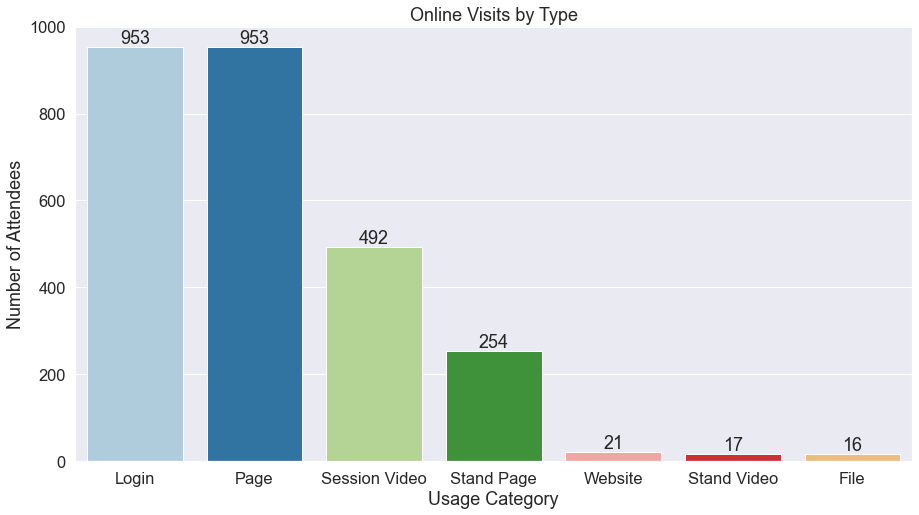

In [23]:
# Plotting online category wise usage into a bar graph

plt.figure(figsize=(15,8))
labels = online_usage_type_df['usage_type']
sizes = online_usage_type_df['no_of_people']
sns.set(font_scale=1.5)
ax = sns.barplot(x=labels, y=sizes, palette = 'Paired')
plt.title("Online Visits by Type")
plt.xlabel("Usage Category")
plt.ylabel("Number of Attendees")
ax.bar_label(ax.containers[0])
plt.show()

### Question: How was the online engagement before and after conference day?

In [25]:
# Query to capture till how many days did people engage with the website after conference ended
engagement_after_conf_day = pd.read_sql_query('''
                            SELECT (latest_visit - conf_end_time) AS days_from_conference, COUNT(DISTINCT(attendeeid)) AS no_of_people FROM 
                            (SELECT attendeeid, conferenceid, CAST(date_visited AS DATE) as latest_visit FROM attendee_log log
                            GROUP BY attendeeid, conferenceid) log
                            INNER JOIN attendees att on log.attendeeid = att.id and att.exhibitoraccount = 0
                            INNER JOIN
                            (SELECT max(CAST(end_time AS DATE)) AS conf_end_time, conferenceid FROM events
                            GROUP BY conferenceid) event
                            ON event.conferenceid = log.conferenceid AND event.conferenceid = 35 AND latest_visit >= conf_end_time
                            GROUP BY days_from_conference;
                            ''',connection)


In [26]:
engagement_after_conf_day.head()

,days_from_conference,no_of_people
0,0,457
1,1,9
2,4,86
3,5,19
4,6,8


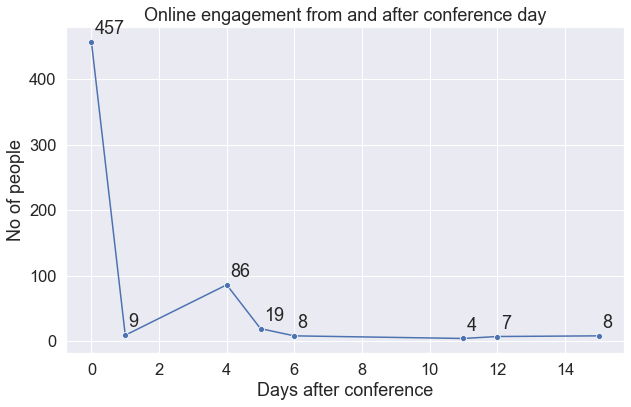

In [31]:
## Plot Data for engaement after conference day into graph

df = engagement_after_conf_day
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
ax = sns.lineplot(x= df.days_from_conference, y= df.no_of_people, markers=True, marker="o")
ax.set(xlabel='Days after conference', ylabel='No of people')
for i,j in zip(df.days_from_conference,df.no_of_people):
    ax.annotate(str(j),xy=(i+0.1,j+12))
plt.title("Online engagement from and after conference day")
plt.show()


In [29]:
# Also we can get enagement before conference day with following query

engagement_before_conf_day = pd.read_sql_query('''
                            SELECT (conf_end_time - latest_visit) AS days_till_conference, COUNT(DISTINCT(attendeeid)) AS no_of_people FROM 
                            (SELECT attendeeid, conferenceid, CAST(date_visited AS DATE) as latest_visit FROM attendee_log log
                            GROUP BY attendeeid, conferenceid) log
                            INNER JOIN attendees att on log.attendeeid = att.id and att.exhibitoraccount = 0
                            INNER JOIN
                            (SELECT max(CAST(end_time AS DATE)) AS conf_end_time, conferenceid FROM events
                            GROUP BY conferenceid) event
                            ON event.conferenceid = log.conferenceid AND event.conferenceid = 35 AND latest_visit < conf_end_time
                            GROUP BY days_till_conference;
                            ''',connection)

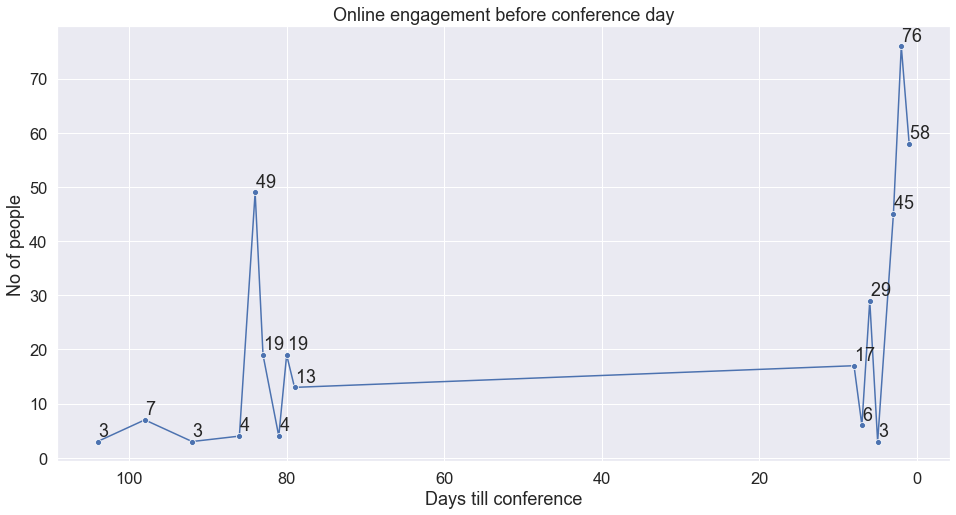

In [33]:
# Graph for engagement before conference day
df2 = engagement_before_conf_day
plt.figure(figsize=(16,8))
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
ax = sns.lineplot(x= df2.days_till_conference,y = df2.no_of_people, markers=True, marker="o")
ax.set(xlabel='Days till conference', ylabel='No of people')
ax.invert_xaxis()
for i,j in zip(df2.days_till_conference,df2.no_of_people):
    ax.annotate(" " + str(j),xy=(i+0.5,j+1))

plt.title("Online engagement before conference day")
plt.show()


### Question : Sentiment analysis of the events

In [3]:
# Query to select all chat messages from database

conv_table_2 = pd.read_sql_query("""
        SELECT mes.id AS message_id, mes.conferenceid, e.id AS event_id, mes.message AS conf_mess, date_sent, 
        e.start_time, e.end_time
        FROM conversation_message mes
        INNER JOIN conversation conv ON conv.id = mes.conversationid AND conv.keytype = 'delegate'
        INNER JOIN events e ON e.start_time IS NOT NULL AND e.end_time IS NOT NULL AND mes.date_sent > e.start_time AND mes.date_sent < e.end_time
        ORDER BY date_sent;
        """, connection)



C:\Users\Nachiket\AppData\Roaming\Python\Python310\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Method required for Data handling of sentiment analysis output, passed into apply function of pandas dataframe to get data
# in the desired format
def get_sentiment(arg):
    return arg.sentiment.polarity

In [5]:
# Perform analysis on chat messages

conv_table_2['sentiment'] = conv_table_2['conf_mess'].apply(TextBlob)

conv_table_2['sentiment'] = conv_table_2['sentiment'].apply(get_sentiment)

pop_events = conv_table_2.groupby('event_id')['sentiment'].mean()

In [ ]:
# Below analysis links chat messages to event based on message times and event time. This can possibly have lower accuracy. 
# Having values for event id in chat messages would have made the analysis more accurate

# Sentiment value of 0 denotes a neutral outlook, while values greater than 0 & less than 1 show a postive outlook
# Sentiment values of less than 0 show a negative outlook

# As we see from the graph all events had slightly positive response from the delegates 
# This shows verall the event was successful.
# It should also be noted that no event score a sentiment value of above 0.5.

# Events at the beginnning of conference denote lower user polarity than events in rest of days
# Manual analysis indicates that this was probably due to delay in starting of events.

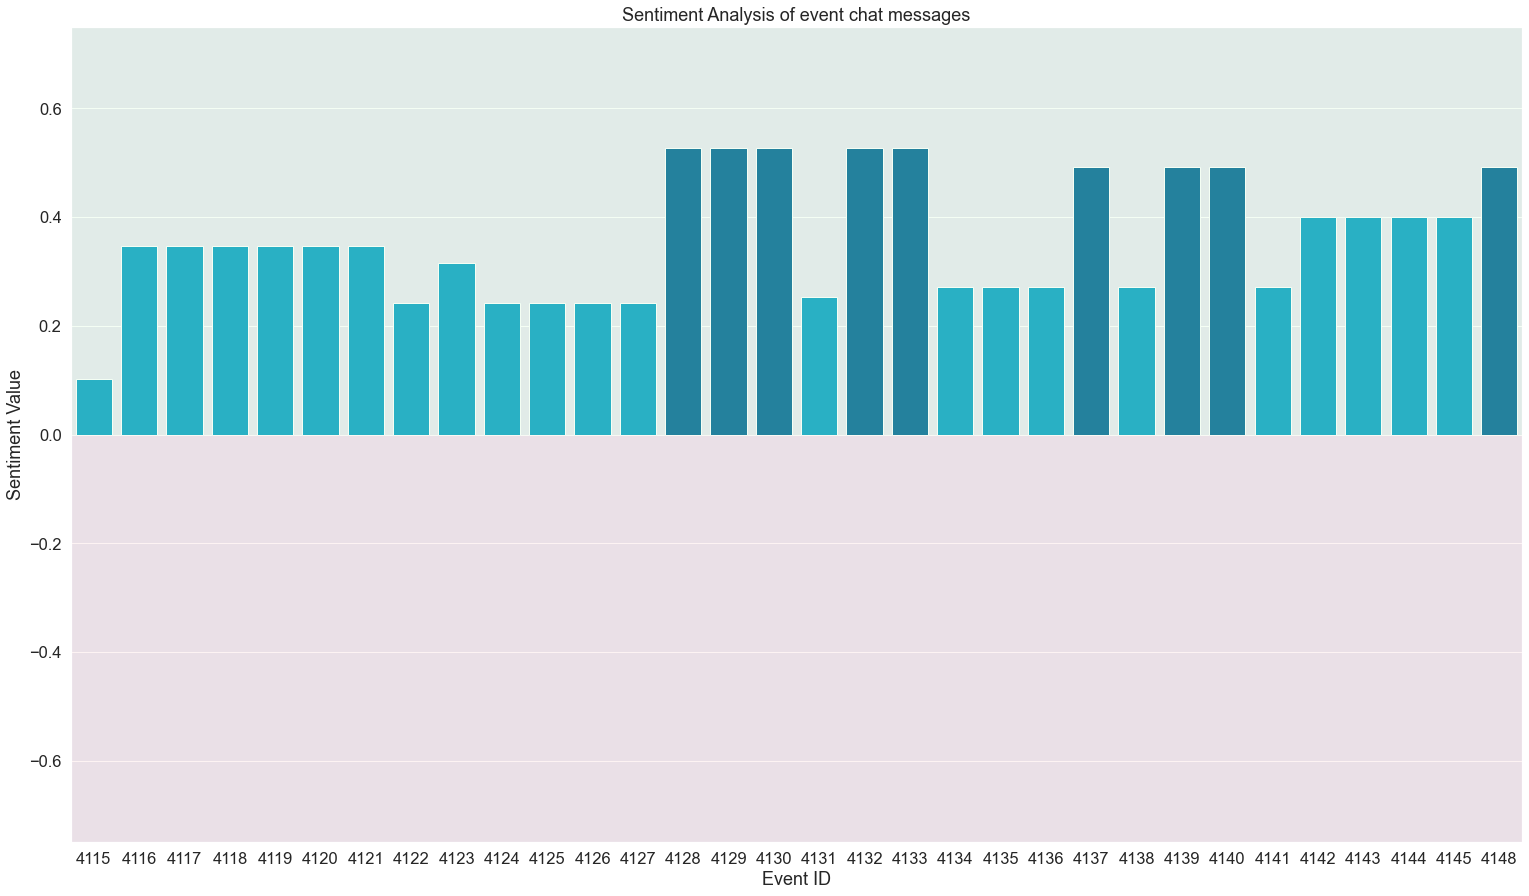

In [11]:
# Chart for sentiment of users in each event
plt.figure(figsize=(26,15))
sns.set(font_scale=1.5)
# sns.barplot(x=pop_events.index, y=pop_events.values, palette="winter")
# plt.ylim(-0.75, 0.75)

clrs = ['#00b9e7' if (x < 0.4) else '#007cb4' for x in pop_events ] #

sns.barplot(x=pop_events.index, y=pop_events.values, palette = clrs)
plt.ylim(-0.75, 0.75)

plt.axhspan(-1, 0, facecolor= '#f28e8e', alpha=0.1) #FF6F61 '#88B04B'
plt.axhspan(0, 1, facecolor='#97fc96', alpha=0.1) #'#aee7f8' '#bae9d5'

plt.title("Sentiment Analysis of event chat messages")
plt.xlabel("Event ID")
plt.ylabel("Sentiment Value")
plt.show()

### Question : How many exhibition stands were visited, for how long?

In [ ]:
#Created view : time_at_stands
#Query to capture the time spent at each stall by each person

'''
CREATE VIEW time_at_stands AS
SELECT attendeeid, eventid, TIMEDIFF(MAX(date_pinged), MIN(date_pinged)) AS TimeSpent
FROM attendee_session_tracking
GROUP BY attendeeid, eventid
ORDER BY attendeeid;
'''

In [5]:
time_at_stands = pd.read_sql_query(''' SELECT * FROM time_at_stands''',connection)

In [ ]:
#Created view : time_at_each_stand
#Query to aggregate all the time spent at each stall

'''
CREATE VIEW time_at_each_stand AS
SELECT eventid, 
SUM(TimeSpent) 
FROM time_at_stands 
GROUP BY eventid;
'''

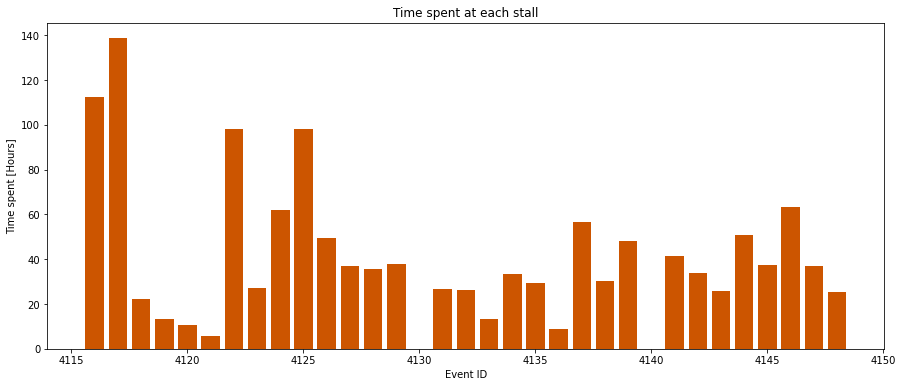

In [17]:
Time_at_each_stand = pd.read_sql_query(''' SELECT * FROM time_at_each_stand''',connection)

# Visualising the total time spent at each stall
data = (Time_at_each_stand['SUM(TimeSpent)'].tolist()[1:])
# Remove the first element as there seems to be an outlier

# Set the width and height of the figure
plt.figure(figsize=(15,6))

# Adjust to make Y axis measure in hours rather than seconds
data[:] = [float(x) / 3600 for x in data]

# Create the graph object
plt.bar(Time_at_each_stand['eventid'].tolist()[1:], data, color = '#cc5500')

# Add axis labels and title
plt.title('Time spent at each stall')
plt.xlabel('Event ID')
plt.ylabel('Time spent [Hours]')

# Show the graph
plt.show();

### Question : How many and what type of questions asked of the speakers by virtual attendees?

In [11]:
unique_visitors = pd.read_sql_query('''
                  select message from conversation_message;
                  ''',connection);

In [12]:
# Setting the amount for each type of question asked

# Questions about technical issues with the stream
Count_TechnicalIssues = 9; #2 Repeated questions
# Event/seminar schedule questions: 
Count_EventQueries = 7;
# Questions about products/ services rendered: 
Count_ServicesRendered = 3;
# Questions where people ask some variation of "how are you doing?"
CountPleasantries = 2;

data = [Count_TechnicalIssues, Count_EventQueries, Count_ServicesRendered, CountPleasantries]

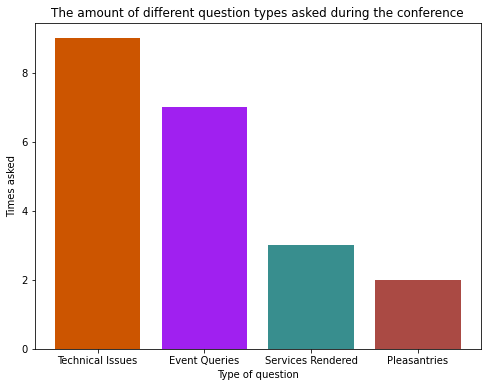

In [13]:
#Visualising the number of each question asked
data = [Count_TechnicalIssues, Count_EventQueries, Count_ServicesRendered, CountPleasantries]

# Setting the width and height of the graph
plt.figure(figsize=(8,6))

# Create the graph object
plt.bar(['Technical Issues','Event Queries','Services Rendered','Pleasantries'], 
        data, color = ['#cc5500', '#A020F0', '#388E8E', '#AA4A44'])

# Add axis labels and title
plt.title('The amount of different question types asked during the conference')
plt.xlabel('Type of question')
plt.ylabel('Times asked')

# Show the graph
plt.show();